<a href="https://colab.research.google.com/drive/13zV09eaXNgB4Duq3DPxuw8RoyvIKi0AZ?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)

# Saliency maps basic example 

This code is based on the main  idea of the well known paper: **Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps**. 

- https://arxiv.org/abs/1312.6034

Where we address the task knowing where in the input are the important pixels that influence the output.

![Saliency maps](https://static.wixstatic.com/media/05769c_520dda1bc6c84c7a8ea8cbc39c210c6b~mv2.jpeg/v1/fill/w_740,h_328,al_c,q_90,usm_0.66_1.00_0.01/05769c_520dda1bc6c84c7a8ea8cbc39c210c6b~mv2.webp)

As shown, the network pays more attention to the important parts the input image (the objects not the background) while the network makes its decisions by classifying the objects.    

## Steps 
- Load a network (NGG16 for instance) 
- Input an image and get the predictions
- Compute the gradients
- Plot the abs(gradients) as gray scale image

In [0]:
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.2.0-rc4
Eager execution: True


In [0]:
from keras.preprocessing import image
from keras import applications
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

Using TensorFlow backend.


In [0]:
# build the VGG16 network
model = applications.VGG16(include_top=True, weights='imagenet')

# get the symbolic outputs of each "key" layer
layer_dict = dict([(layer.name, layer) for layer in model.layers])

for layer in model.layers:
  print(layer.name)

553467904/553467096 [==============================] - 5s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
fc1
fc2
predictions


2020-05-10 19:24:20 URL:https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg [83281/83281] -> "ex01.jpg" [1]


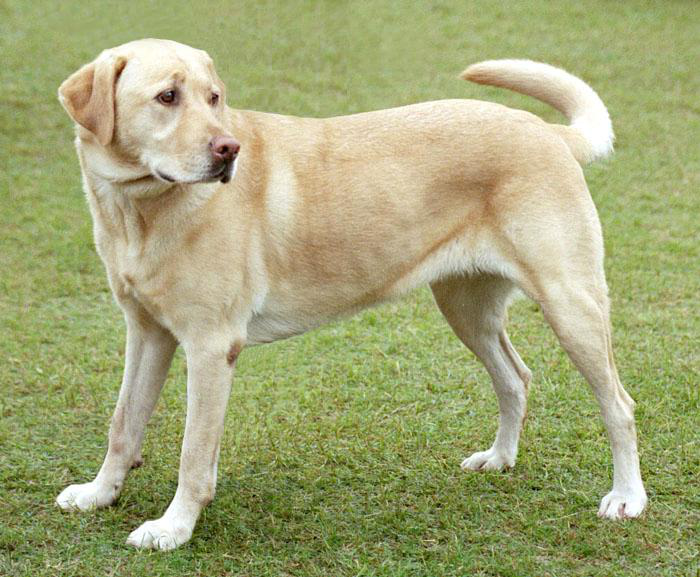

In [0]:
# Load a sample image
!wget -nv https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg -O ex01.jpg

img = Image.open('./ex01.jpg')
img

In [0]:
img_path = './ex01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
print('image.img_to_array: ', x.shape, np.max(x), np.min(x))
x = np.expand_dims(x, axis=0)
print('expand_dims: ', x.shape, np.max(x), np.min(x))
x = preprocess_input(x)
print('preprocess_input: ', x.shape, np.max(x), np.min(x))

image.img_to_array:  (224, 224, 3) 255.0 0.0
expand_dims:  (1, 224, 224, 3) 255.0 0.0
preprocess_input:  (1, 224, 224, 3) 151.061 -123.68


In [0]:
# util function to convert a tensor into a valid image
def tensor2image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.2
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
preds = model.predict(x)
# Get results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02099712', 'Labrador_retriever', 0.36154297), ('n02099601', 'golden_retriever', 0.2183722), ('n02099849', 'Chesapeake_Bay_retriever', 0.049494296)]


In [0]:
model_out = K.mean(layer_dict['fc2'].output)
# compute the gradient of the input picture wrt this loss
grads = K.gradients(model_out, model.input)[0]

# Normalize the gradient
grads /= K.std(grads) + 1e-8

# function: returns the loss and grads given the input picture
model_predictor = K.function([model.input], [model_out, grads])

In [0]:
# feed  the image to the network
model_outputs, grads_values = model_predictor([x])

In [0]:
# get the grads that have the same shape  as the input image  
abs_grads_values = np.abs(grads_values)
sm = tensor2image(abs_grads_values[0])
print(sm.shape)

(224, 224, 3)


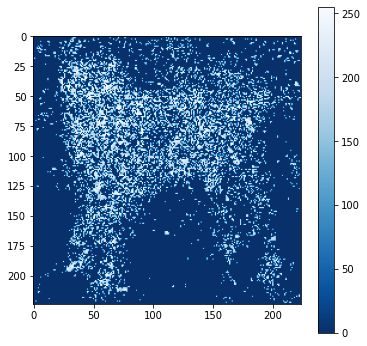

In [0]:
# let's see the grads as an image
gs = sm[:,:,0] + sm[:,:,1] + sm[:,:,2]
gs[gs<150] = 0
plt.figure(figsize=(6,6))
plt.imshow(gs, cmap='Blues_r')
plt.colorbar()

It is clear that the network pays more attention on the object not the background

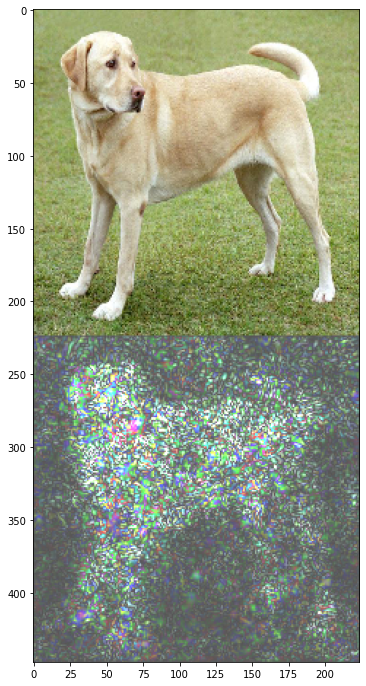

In [0]:
x1 = image.img_to_array(img).astype('uint8')
concan = np.concatenate((x1, sm), axis=0) 
plt.figure(figsize=(12,12))
plt.imshow(concan)